In [ ]:
!pip install pybullet
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

# Configurar pantalla virtual para renderizado
from pyvirtualdisplay import Display
disp = Display(visible=0, size=(1400, 900))
disp.start()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.2 MB/s eta 0:00:00


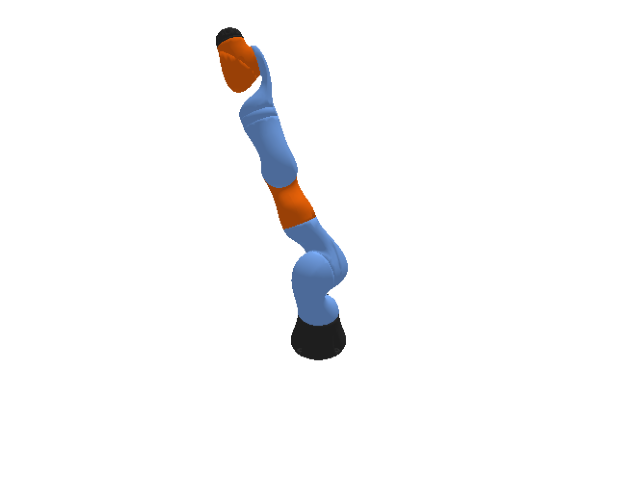

In [ ]:
import pybullet as p
import pybullet_data
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display

# Primero desconectar cualquier instancia existente de PyBullet
if p.isConnected():
    p.disconnect()

# Inicializar nueva conexión
physicsClient = p.connect(p.GUI)

# Configurar la ruta de búsqueda para los datos
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -10)

# Cargar el robot UR5 - usando la ruta completa en pybullet_data
# pybullet_data incluye algunos modelos, pero puede que necesites la ruta específica
try:
    # Intenta cargar desde los modelos integrados en pybullet_data
    robot_id = p.loadURDF("ur5/ur5.urdf", [0, 0, 0], useFixedBase=True)
except p.error:
    # Si falla, intentemos alternativas comunes
    try:
        robot_id = p.loadURDF("ur_description/urdf/ur5.urdf", [0, 0, 0], useFixedBase=True)
    except p.error:
        # Si también falla, probemos con el modelo más común disponible en pybullet_data
        print("No se pudo cargar el modelo UR5, cargando robot alternativo...")
        robot_id = p.loadURDF("kuka_iiwa/model.urdf", [0, 0, 0], useFixedBase=True)

# Configuración de la cámara
p.resetDebugVisualizerCamera(cameraDistance=1.5, cameraYaw=90, cameraPitch=-30, cameraTargetPosition=[0, 0, 0.5])

# Obtener información de las articulaciones
num_joints = p.getNumJoints(robot_id)
joint_indices = [i for i in range(num_joints) if p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE]

# Posiciones objetivo para las articulaciones
# Asegurarse de que el número de posiciones objetivo sea igual al número de articulaciones
target_positions = [np.deg2rad(45), np.deg2rad(-30), np.deg2rad(60),
                   np.deg2rad(0), np.deg2rad(90), np.deg2rad(0)]

# Si tenemos menos posiciones objetivo que articulaciones, ajustamos
if len(target_positions) > len(joint_indices):
    target_positions = target_positions[:len(joint_indices)]
elif len(target_positions) < len(joint_indices):
    # Rellenar con ceros si faltan posiciones
    target_positions.extend([0] * (len(joint_indices) - len(target_positions)))

# Control de posición para las articulaciones
for i, joint_idx in enumerate(joint_indices):
    p.setJointMotorControl2(
        bodyUniqueId=robot_id,
        jointIndex=joint_idx,
        controlMode=p.POSITION_CONTROL,  # Corregido "controMode" a "controlMode"
        targetPosition=target_positions[i],
        targetVelocity=0,
        force=500
    )

# Simulación y visualización
plt.figure(figsize=(8, 6))
for _ in range(100):
    p.stepSimulation()
    time.sleep(0.01)

    # Captura de imagen de la cámara
    width, height, rgbImg, depthImg, segImg = p.getCameraImage(
        width=640,
        height=480,
        viewMatrix=p.computeViewMatrixFromYawPitchRoll(
            cameraTargetPosition=[0, 0, 0.5],
            distance=1.5,
            yaw=90,
            pitch=-30,
            roll=0,
            upAxisIndex=2
        ),
        projectionMatrix=p.computeProjectionMatrixFOV(
            fov=60,
            aspect=640 / 480,
            nearVal=0.1,
            farVal=100
        )
    )

    # Mostrar imagen
    plt.clf()
    plt.imshow(rgbImg)
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

# Desconectar al finalizar
p.disconnect()